In [1]:
#Settings

import numpy as np
# from scipy.sparse import csc_matrix
import scanpy as sc
import pandas as pd
import decoupler as dc
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.set_figure_params(dpi=300, frameon=False, facecolor="white")
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

plt.rcParams["font.family"] = "Arial"
sc.set_figure_params(figsize=(6, 6))
# Change global font weight


font = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 20,
    'style'  : 'normal'}

matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial'

matplotlib.rc('font', **font)
#matplotlib.rc('font', **font0)
matplotlib.rc('text', usetex=False)

# Define your colormap
cmap = 'viridis'  # Or any colormap you prefer

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


In [2]:
from anndata import read_h5ad

# Reload the adata object
#adata = read_h5ad('/home/liza/Documents/PhD/scRNAseq_Inbal/adata.h5ad')

# Reload the adata_T object
adata_T = read_h5ad('/home/liza/Documents/PhD/scRNAseq_Inbal/adata_T.h5ad')

In [3]:
adata_T

AnnData object with n_obs × n_vars = 8303 × 1958
    obs: 'n_genes', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/plotting/_utils.py:

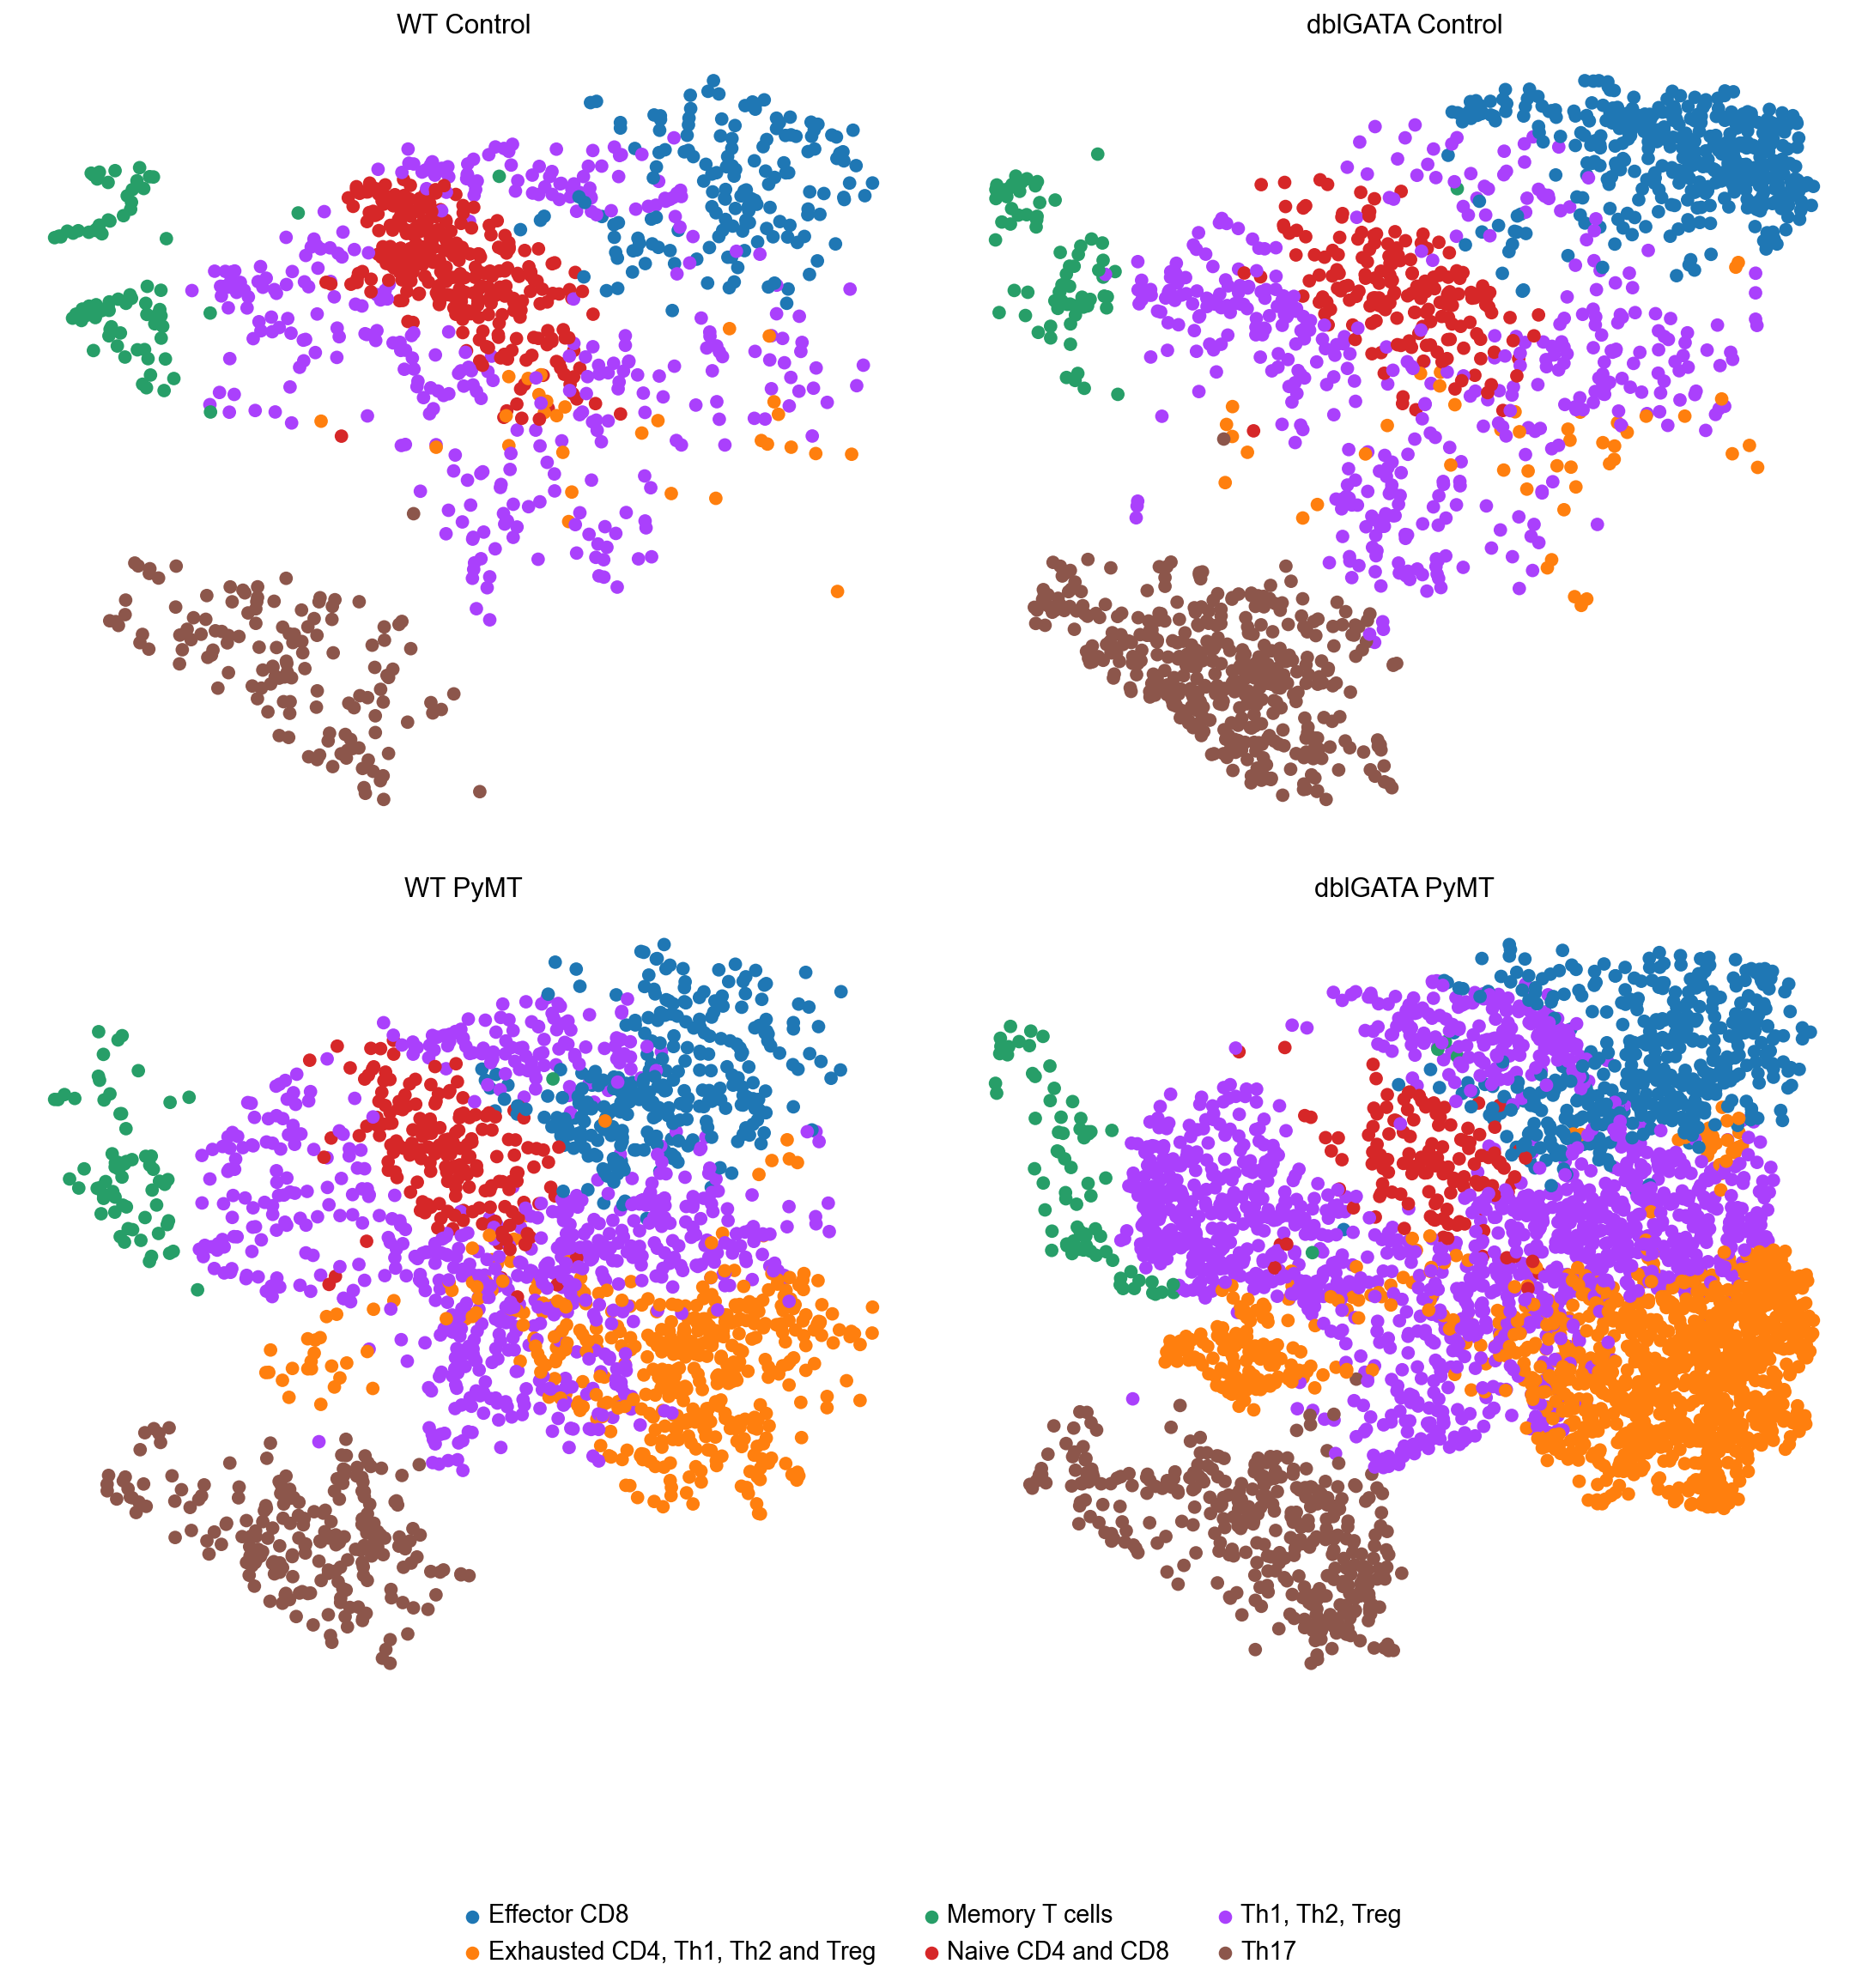

In [4]:
# %% Subplots for 4 samples

import matplotlib.pyplot as plt

# Create a figure with 4 subplots (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Define samples and subplot titles
samples = ['WT_Control', 'dblGATA_Control', 'WT_PyMT', 'dblGATA_PyMT']
subplot_titles = ['WT Control', 'dblGATA Control', 'WT PyMT', 'dblGATA PyMT']

# Collect legend handles and labels
all_handles = []
all_labels = []

# Plot UMAP for each sample in a different subplot
for i, sample in enumerate(samples):
    ax = axs[i // 2, i % 2]
    sc.pl.umap(adata_T[adata_T.obs['sample'] == sample], ax=ax, color='cell_type',
               title=subplot_titles[i], show=False, frameon=False, size=200, cmap = cmap)
    handles, labels = ax.get_legend_handles_labels()
    all_handles.extend(handles)
    all_labels.extend(labels)

# Hide legends for all subplots
for ax in axs.flat:
    ax.get_legend().remove()

# Deduplicate handles and labels
unique_handles = []
unique_labels = []
for h, l in zip(all_handles, all_labels):
    if l not in unique_labels:
        unique_handles.append(h)
        unique_labels.append(l)

# Place the legend outside of the subplots
leg = fig.legend(unique_handles, unique_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
                 ncol=3, borderaxespad=0., frameon=False)

# Adjust the layout to make space for the legend
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure with the legend
plt.savefig('/home/liza/Documents/PhD/scRNAseq_Inbal/umap_T_plots_with_legend.tiff', bbox_extra_artists=(leg,), bbox_inches='tight', format='tiff', dpi=300)# For high-resolution TIFF format

# Display the plot
plt.show()

plt.close()


/tmp/ipykernel_17211/1763612089.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata_df.groupby(['sample', 'cell_type']).size().reset_index(name='counts')
/tmp/ipykernel_17211/1763612089.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_totals = cell_type_counts.groupby('cell_type')['counts'].sum().reset_index(name='total_counts')


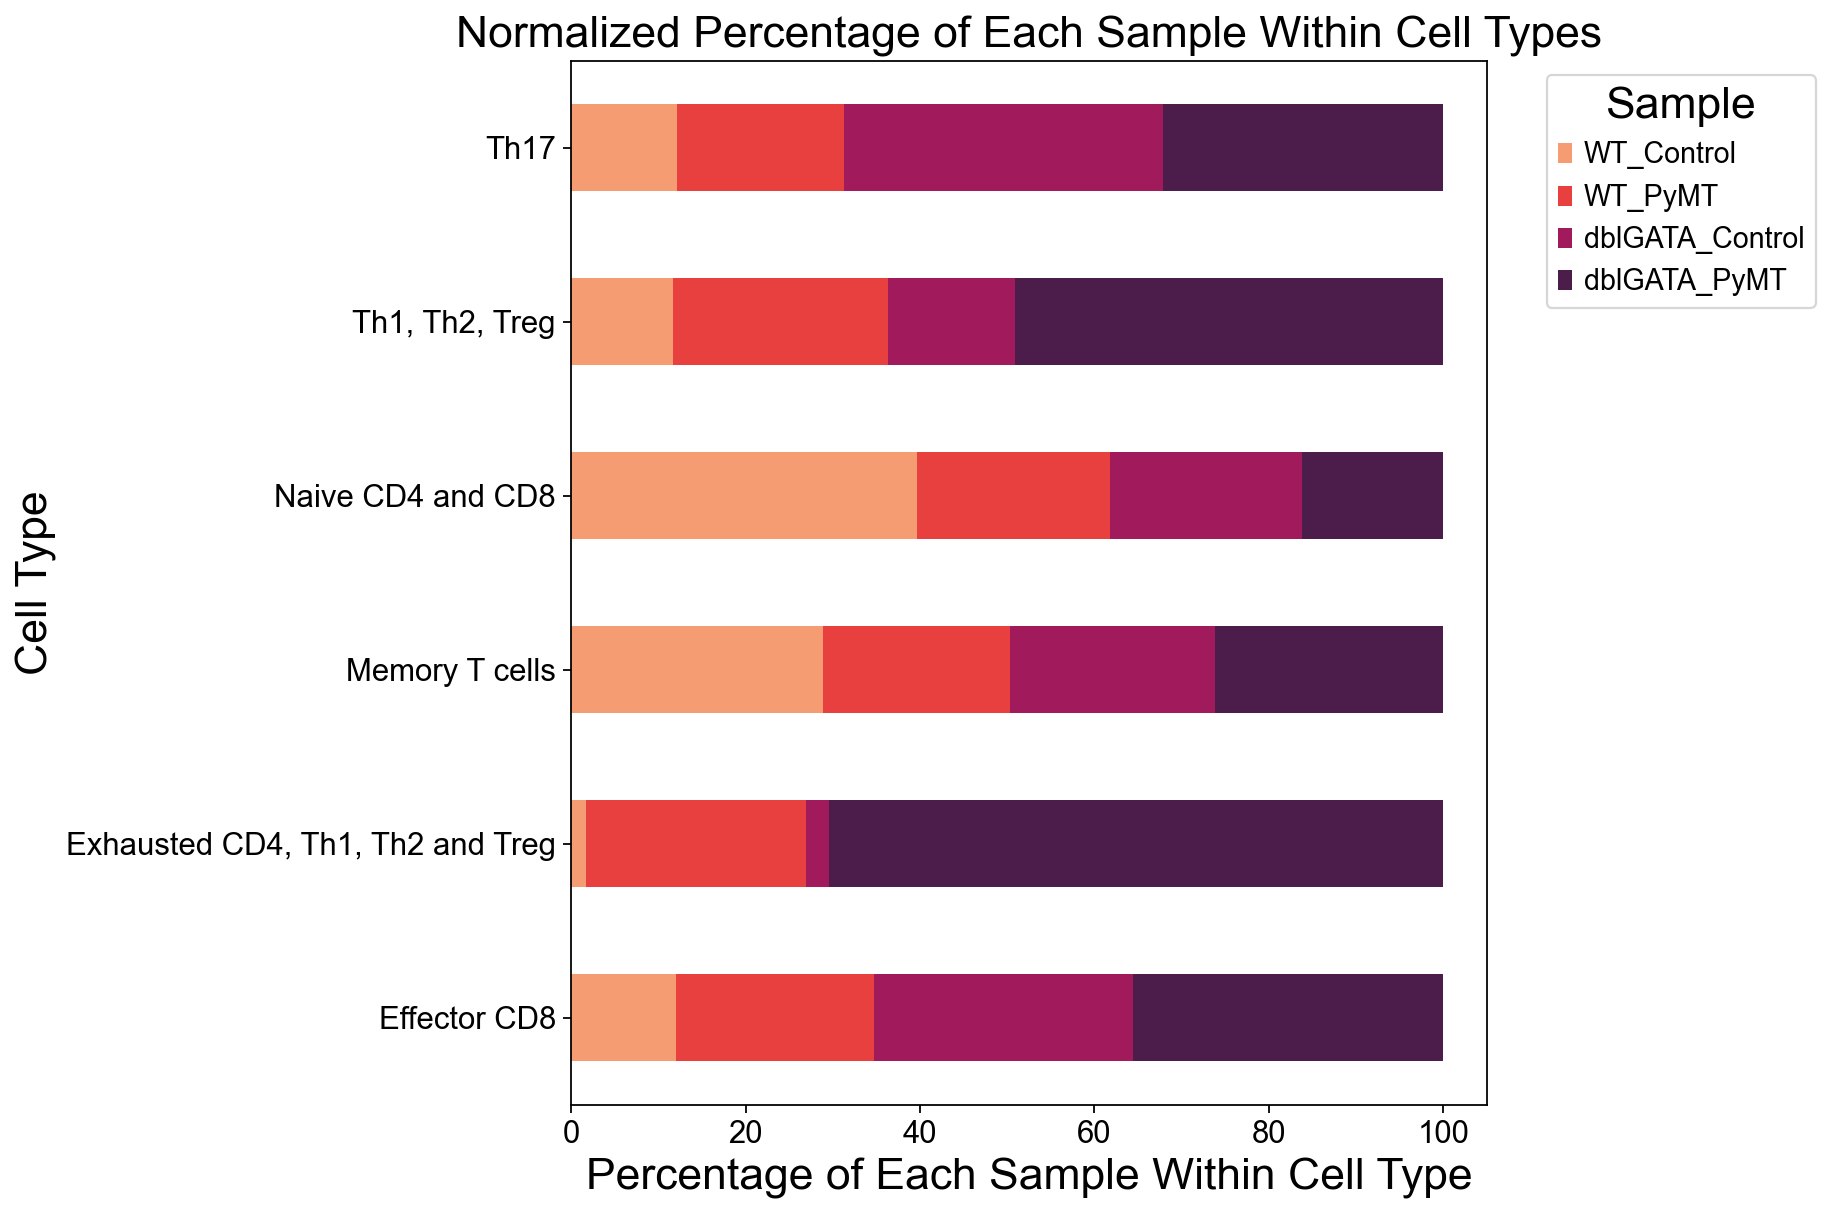

In [6]:
# Barplot for every cell type

# Convert to a pandas DataFrame
adata_df = pd.DataFrame(adata_T.obs)

# Calculate the counts of each cell type within each sample
cell_type_counts = adata_df.groupby(['sample', 'cell_type']).size().reset_index(name='counts')

# Calculate the total number of cells for each cell type across all samples
cell_type_totals = cell_type_counts.groupby('cell_type')['counts'].sum().reset_index(name='total_counts')

# Merge the counts with the totals to calculate percentages
cell_type_counts = cell_type_counts.merge(cell_type_totals, on='cell_type')
cell_type_counts['percent'] = (cell_type_counts['counts'] / cell_type_counts['total_counts']) * 100

# Filter for the samples of interest
samples_of_interest = ['WT_Control', 'dblGATA_Control', 'WT_PyMT', 'dblGATA_PyMT']
cell_type_counts = cell_type_counts[cell_type_counts['sample'].isin(samples_of_interest)]

# Pivot the data for plotting
cell_type_counts_pivot = cell_type_counts.pivot(index='cell_type', columns='sample', values='percent').fillna(0)

# Reverse the order of colors in the 'rocket' palette
palette = sns.color_palette("rocket", n_colors=len(samples_of_interest))[::-1]

# Plotting
ax = cell_type_counts_pivot.plot(kind='barh', stacked=True, figsize=(12, 8), color=palette)

# Remove grid
ax.grid(False)

# Add labels and title
plt.xlabel('Percentage of Each Sample Within Cell Type', fontsize=20)
plt.ylabel('Cell Type', fontsize=20)
plt.title('Normalized Percentage of Each Sample Within Cell Types', fontsize=20)

# Show legend and plot
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the figure with the legend
plt.savefig('/home/liza/Documents/PhD/scRNAseq_Inbal/T-cluster_cells_combination_cell_type.tiff', format='tiff', dpi=300)

plt.show()
plt.close()


In [5]:
adata = read_h5ad('/home/liza/Documents/PhD/scRNAseq_Inbal/adata.h5ad')

In [6]:
WT_Control = adata[adata.obs['sample'] == "WT_Control"]
WT_Control_T = adata_T[adata_T.obs['sample'] == "WT_Control"]

In [7]:
dblGATA_Control = adata[adata.obs['sample'] == "dblGATA_Control"]
dblGATA_Control_T = adata_T[adata_T.obs['sample'] == "dblGATA_Control"]
dblGATA_Control_T.n_obs/dblGATA_Control.n_obs

0.1521889514774187

In [8]:
WT_Control_T.n_obs/WT_Control.n_obs

0.16884531590413943

In [9]:
WT_PyMT = adata[adata.obs['sample'] == "WT_PyMT"]
WT_PyMT_T = adata_T[adata_T.obs['sample'] == "WT_PyMT"]
WT_PyMT_T.n_obs/WT_PyMT.n_obs

0.3331616005495449

In [10]:
dblGATA_PyMT = adata[adata.obs['sample'] == "dblGATA_PyMT"]
dblGATA_PyMT_T = adata_T[adata_T.obs['sample'] == "dblGATA_PyMT"]
dblGATA_PyMT_T.n_obs/dblGATA_PyMT.n_obs

0.4099133676938261

/tmp/ipykernel_17211/1657764658.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata_df.groupby(['sample', 'cell_type']).size().reset_index(name='counts')
/tmp/ipykernel_17211/1657764658.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_totals = cell_type_counts.groupby('cell_type')['counts'].sum().reset_index(name='total_counts')


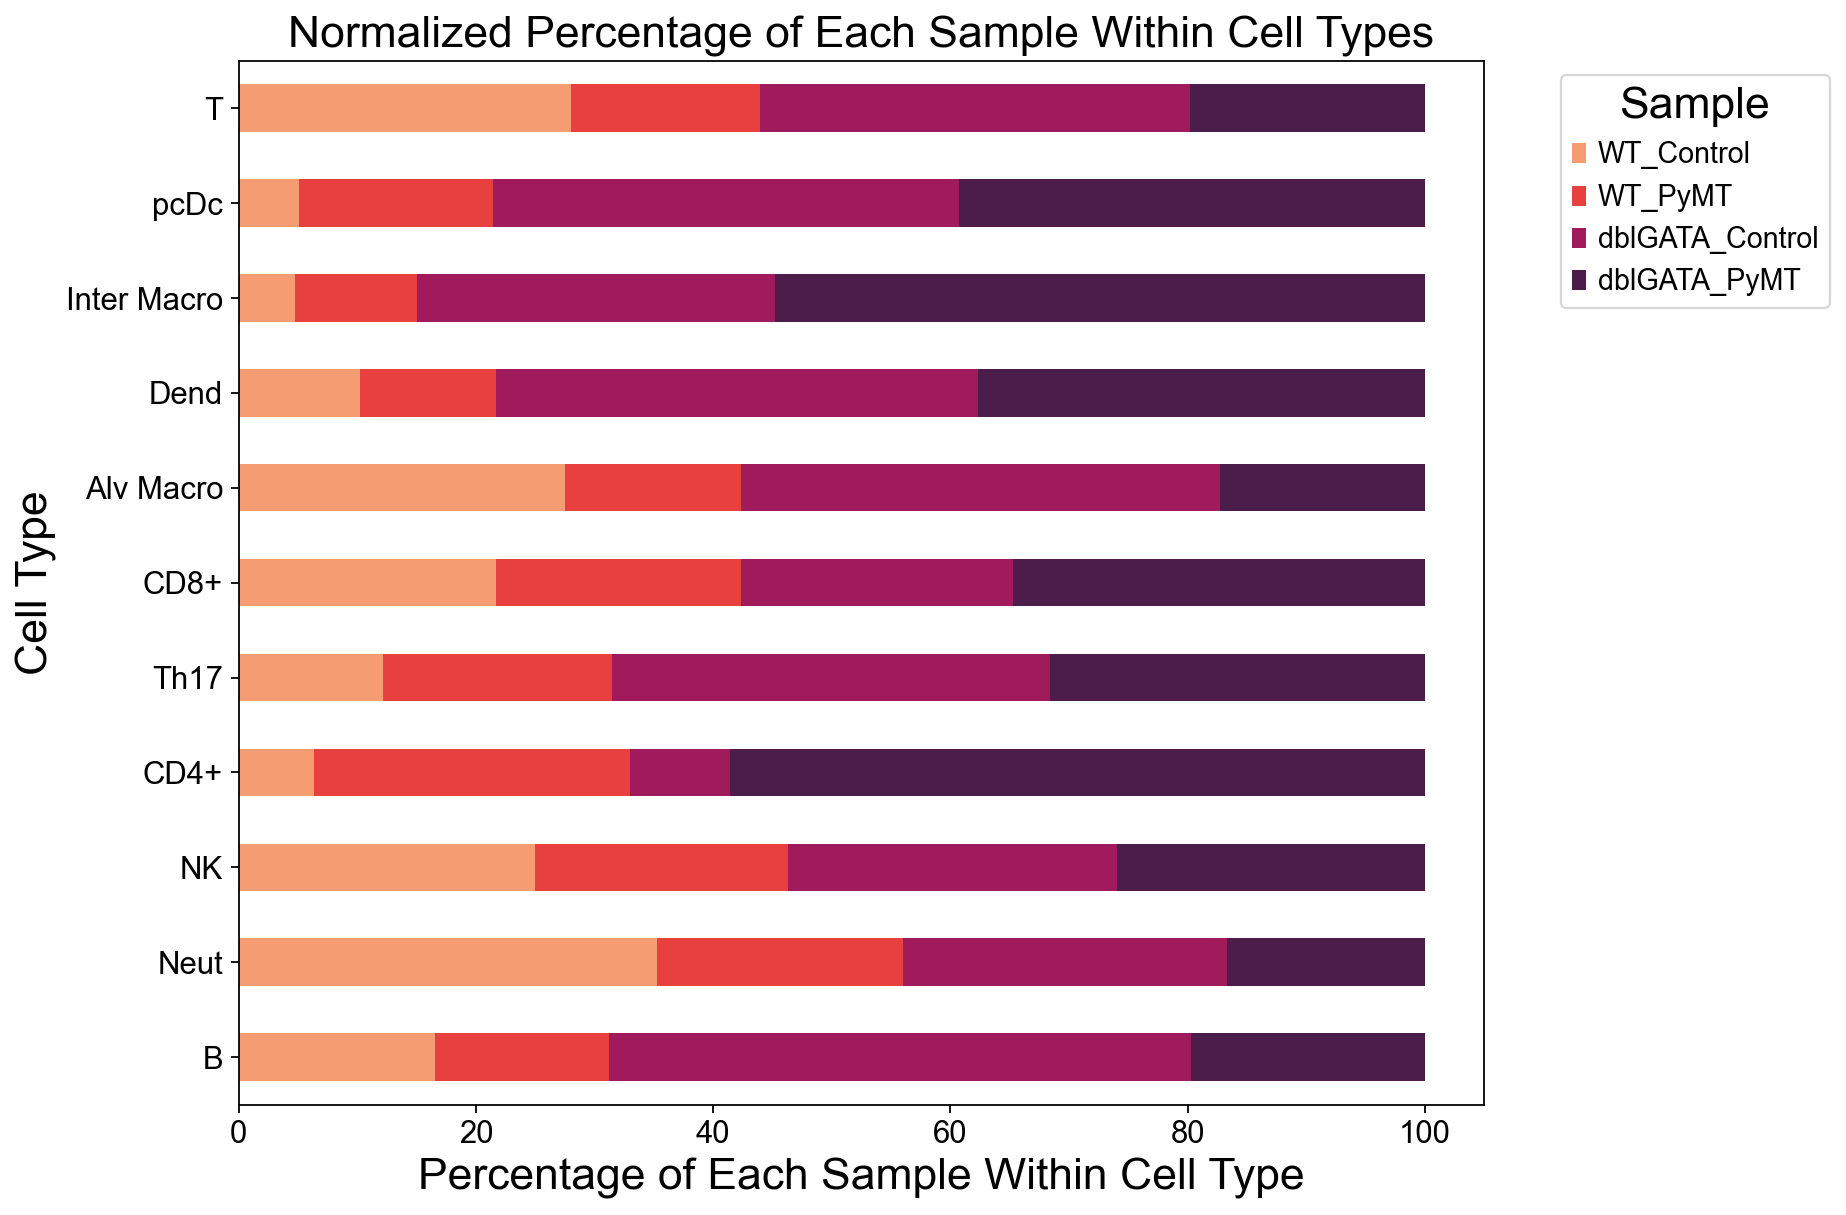

In [8]:
# Barplot for every cell type

# Convert to a pandas DataFrame
adata_df = pd.DataFrame(adata.obs)

# Calculate the counts of each cell type within each sample
cell_type_counts = adata_df.groupby(['sample', 'cell_type']).size().reset_index(name='counts')

# Calculate the total number of cells for each cell type across all samples
cell_type_totals = cell_type_counts.groupby('cell_type')['counts'].sum().reset_index(name='total_counts')

# Merge the counts with the totals to calculate percentages
cell_type_counts = cell_type_counts.merge(cell_type_totals, on='cell_type')
cell_type_counts['percent'] = (cell_type_counts['counts'] / cell_type_counts['total_counts']) * 100

# Filter for the samples of interest
samples_of_interest = ['WT_Control', 'dblGATA_Control', 'WT_PyMT', 'dblGATA_PyMT']
cell_type_counts = cell_type_counts[cell_type_counts['sample'].isin(samples_of_interest)]

# Pivot the data for plotting
cell_type_counts_pivot = cell_type_counts.pivot(index='cell_type', columns='sample', values='percent').fillna(0)

# Reverse the order of colors in the 'rocket' palette
palette = sns.color_palette("rocket", n_colors=len(samples_of_interest))[::-1]

# Plotting
ax = cell_type_counts_pivot.plot(kind='barh', stacked=True, figsize=(12, 8), color=palette)

# Remove grid
ax.grid(False)

# Add labels and title
plt.xlabel('Percentage of Each Sample Within Cell Type', fontsize=20)
plt.ylabel('Cell Type', fontsize=20)
plt.title('Normalized Percentage of Each Sample Within Cell Types', fontsize=20)

# Show legend and plot
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the figure with the legend
plt.savefig('/home/liza/Documents/PhD/scRNAseq_Inbal/T-cluster_cells_combination_cell_type.tiff', format='tiff', dpi=300)

plt.show()
plt.close()

/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'nor

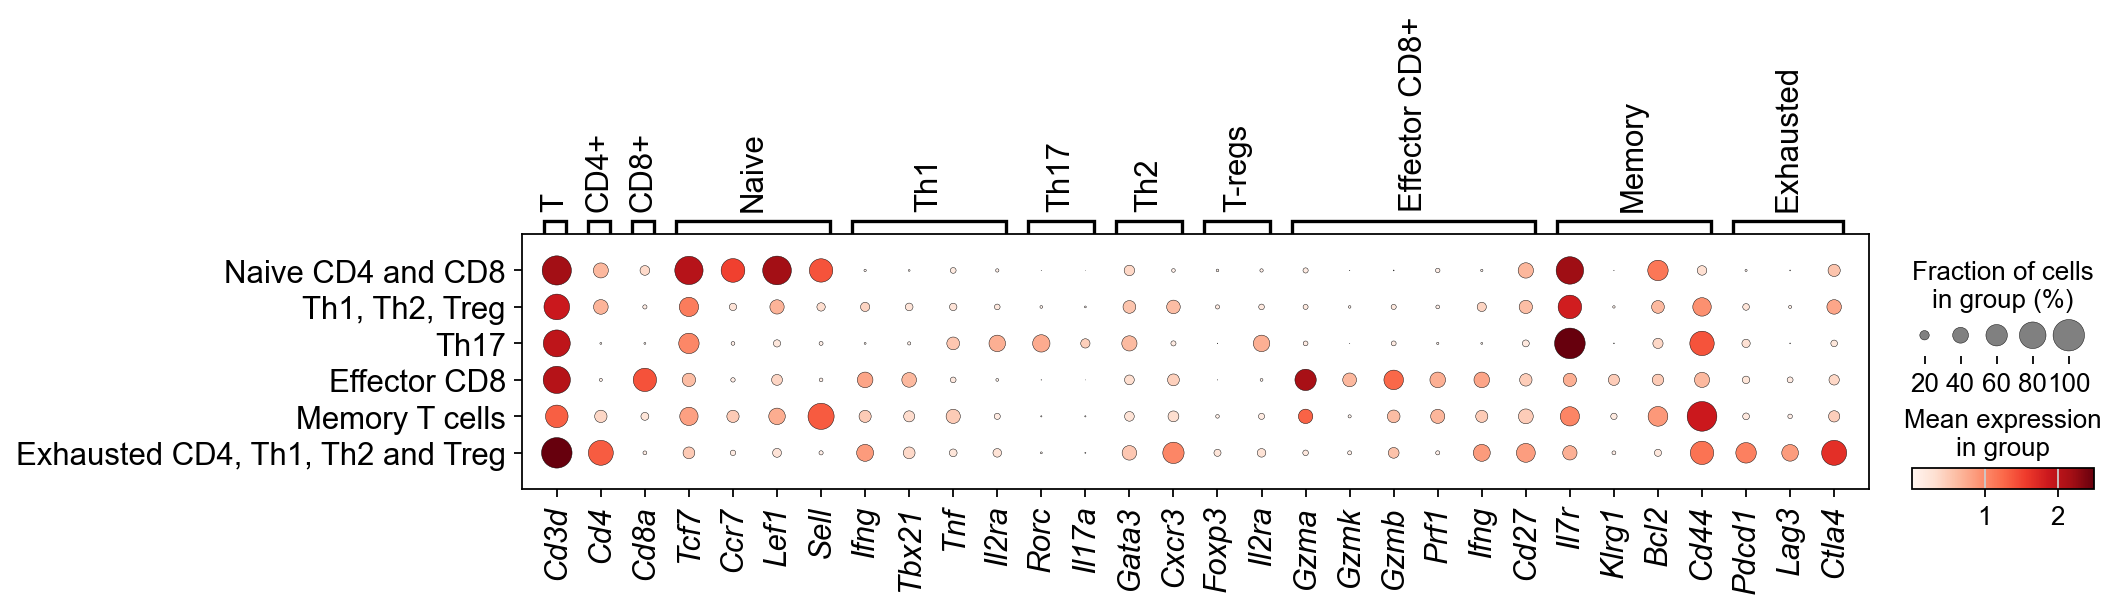

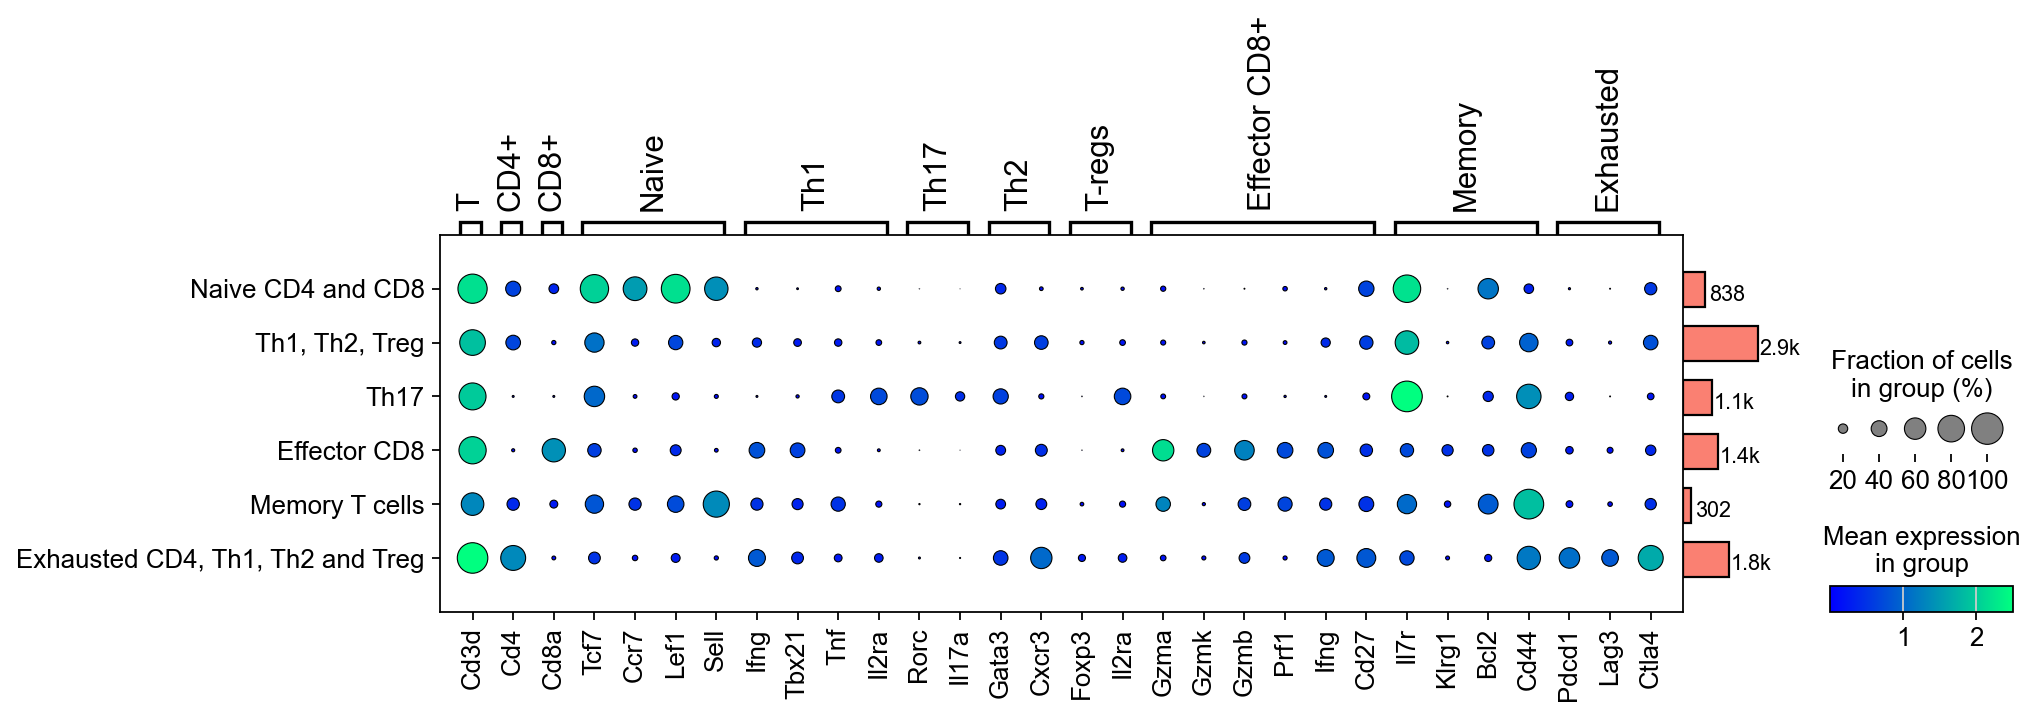

In [11]:
# Dotplot of all T cells

sc.set_figure_params(figsize=(10, 20))


# Define the desired order for the samples
celltypes_order = ['Naive CD4 and CD8', 'Th1, Th2, Treg', 'Th17', 'Effector CD8', 
                   'Memory T cells', 'Exhausted CD4, Th1, Th2 and Treg']

# Convert the 'sample' column to a categorical type with the specified order
adata_T.obs['cell_type'] = pd.Categorical(adata_T.obs['cell_type'], categories=celltypes_order, ordered=True)


# List of marker genes for different T cell states
marker_genes = {
    'T': ['Cd3d'],
    'CD4+': ['Cd4'],
    'CD8+': ['Cd8a'],
    'Naive': ['Tcf7', 'Ccr7', 'Lef1', 'Sell'],
    'Th1': ['Ifng', 'Tbx21', 'Tnf', 'Il2ra'],
    'Th17': ['Rorc', 'Il17a'],
    'Th2': ['Gata3', 'Cxcr3'],
    'T-regs': ['Foxp3', 'Il2ra'],
    'Effector CD8+': ['Gzma', 'Gzmk', 'Gzmb', 'Prf1', 'Ifng', 'Cd27'],
    'Memory': ['Il7r', 'Klrg1', 'Bcl2', 'Cd44'],
    'Exhausted': ['Pdcd1', 'Lag3', 'Ctla4']
}

# Perform dot plot
dp = sc.pl.dotplot(adata_T, marker_genes, groupby='cell_type', vmax = 2.5, return_fig=True)

#new_ytick_names = ['B cells', 'Neutrophils', 'NK', 'CD4+', 'Th17', 'CD8+', 'Alveolar Macro', 'Dendritic cells', 'Interstitial Macro', 'pcDc', 'Non defined']

# Accessing the axes and modifying x-tick labels
axes_dict = dp.get_axes()
mainplot_ax = axes_dict['mainplot_ax']

for label in mainplot_ax.get_xticklabels():
    label.set_fontstyle('italic')
    label.set_fontsize(14)
for label in mainplot_ax.get_yticklabels():
    label.set_fontsize(14)


# Annotate clusters with their corresponding T cell states

cluster_to_state = {
        '0': 'Naive CD4+ T',
        '1': 'Th1',
        '2': 'Th17',
        '3': 'Th2',
        '4': 'Tregs',
        '5': 'Naive CD8+ T',
        '6': 'Effector CD8+ T',
        '7': 'Memory CD8+ T',
        '8': 'Exhausted CD8+ T'
    }
# Show the plot
    
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()

# If plt.draw() does not reflect changes, try explicitly showing the figure again
plt.show()

In [15]:
# COUNT the percantage of GENE

from scipy.sparse import issparse

# Make sure to use the correct gene names as they appear in your dataset
genes_of_interest = ['Foxp3']

# Access the 'counts' layer
counts = adata_T[adata_T.obs['sample'] == 'dblGATA_Control'].layers['counts']

# Find indices of the genes of interest in the dataset
gene_indices = []
for gene in genes_of_interest:
    idx = np.where(adata_T.var_names == gene)
    if idx[0].size > 0:
        gene_indices.append(idx[0][0])
    else:
        print(f"Gene not found: {gene}")

# Check if gene_indices is empty
if not gene_indices:
    raise ValueError("One or more specified genes were not found in the dataset.")

# Convert the counts matrix to a dense format if it's sparse
if issparse(counts):
    counts_dense = counts.toarray()
else:
    counts_dense = counts

# Given gene_indices = [1918, 35, 84, 36]
# Filter cells where all specified genes have counts > 10
cells_with_genes_over_10 = np.all(counts_dense[:, gene_indices] > 0, axis=1)

# Calculate the percentage of such cells
percentage = np.mean(cells_with_genes_over_10) * 100

print(f"Percentage of cells expressing all specified genes with counts > 0: {percentage:.2f}%")

Percentage of cells expressing all specified genes with counts > 0: 3.70%


normalizing counts per cell
    finished (0:00:00)


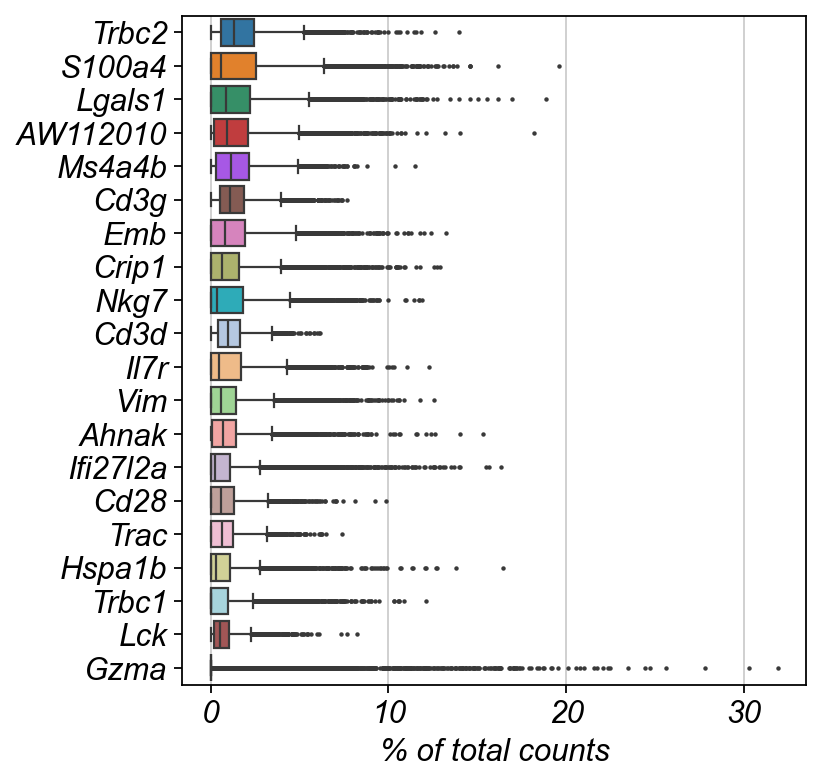

In [7]:
# Total gene highest counts

# Set matplotlib's global font settings to italic for all text
plt.rcParams['font.style'] = 'italic'

# Backup the original .X matrix
original_X = adata_T.X.copy()

# Temporarily set the .X attribute to the raw counts from layers['counts']
adata_T.X = adata_T.layers['counts']

# Plot the highest expression genes using the raw counts
sc.pl.highest_expr_genes(adata_T, n_top=20)  # Adjust n_top as needed

# Restore the original .X matrix
adata_T.X = original_X

# If you want to reset the font style back to normal for subsequent plots, do the following:
plt.rcParams['font.style'] = 'normal'

/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'nor

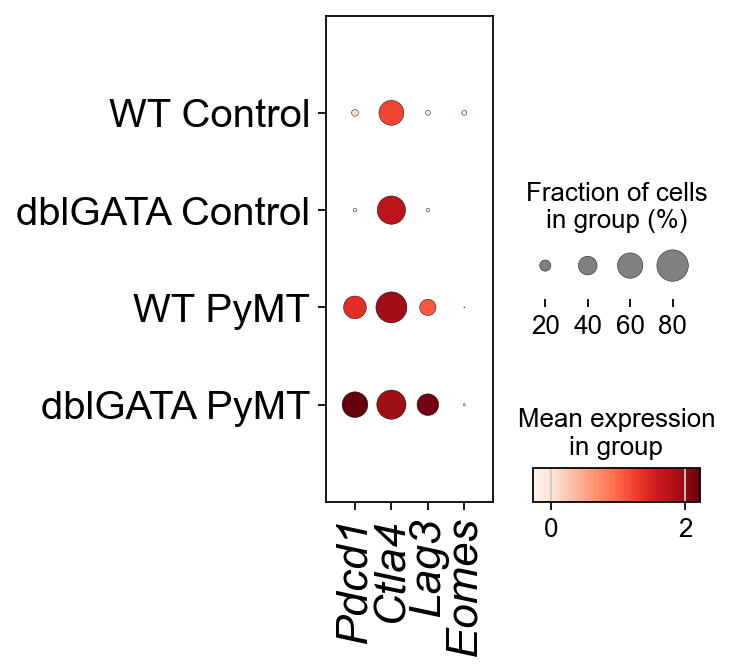

In [8]:
#dot Plot for genes in different clusters: "Exhausted cluster"

# Define the desired order for the samples
samples_order = ['WT_Control', 'dblGATA_Control', 'WT_PyMT', 'dblGATA_PyMT']

# Convert the 'sample' column to a categorical type with the specified order
adata_T.obs['sample'] = pd.Categorical(adata_T.obs['sample'], categories=samples_order, ordered=True)

# Now, subset the AnnData object to only include the desired cell type
adata_subset = adata_T[(adata_T.obs['cell_type'] == 'Exhausted CD4, Th1, Th2 and Treg') | (adata_T.obs['cell_type'] == 'Exhausted CD4, Th1 and Th2')]

# Define the genes of interest
genes_of_interest = ['Pdcd1', 'Ctla4', 'Lag3', 'Eomes']

# Create the dot plot
dp = sc.pl.dotplot(adata_subset, var_names=genes_of_interest, groupby='sample', use_raw = False, return_fig = True, figsize = (3,4))

# Accessing the axes and modifying x-tick labels
axes_dict = dp.get_axes()
mainplot_ax = axes_dict['mainplot_ax']
new_ytick_names = ['WT Control', 'dblGATA Control', 'WT PyMT', 'dblGATA PyMT']  # Example names


for label in mainplot_ax.get_xticklabels():
    label.set_fontstyle('italic')
    label.set_fontsize(20)
for label in mainplot_ax.get_yticklabels():
    label.set_fontsize(18)

mainplot_ax.set_yticklabels(new_ytick_names, fontsize=18)


# Save the figure with the legend
plt.savefig('/home/liza/Documents/PhD/Figures/ExhGenes_Exh_cluster.tiff', bbox_inches='tight', format='tiff', dpi=300)# For high-resolution TIFF format

plt.show()

plt.close()


In [12]:
adata_T. obs['cell_type']

GC_AAACCCAAGGCTTCCG-1                      Th1, Th2, Treg
GC_AAACCCAAGTCTTGGT-1                      Th1, Th2, Treg
GC_AAACCCAGTGAACGGT-1                      Th1, Th2, Treg
GC_AAACCCATCTAGCCAA-1                                Th17
GC_AAACGAATCGTAGAGG-1                                Th17
                                       ...               
WP_TTTGGAGAGACTTGTC-1    Exhausted CD4, Th1, Th2 and Treg
WP_TTTGGAGAGCAATAAC-1                                Th17
WP_TTTGTTGAGAGAAGGT-1                   Naive CD4 and CD8
WP_TTTGTTGCAACGCCCA-1    Exhausted CD4, Th1, Th2 and Treg
WP_TTTGTTGGTAAGATAC-1                      Th1, Th2, Treg
Name: cell_type, Length: 8303, dtype: category
Categories (6, object): ['Naive CD4 and CD8' < 'Th1, Th2, Treg' < 'Th17' < 'Effector CD8' < 'Memory T cells' < 'Exhausted CD4, Th1, Th2 and Treg']

In [13]:
# %% Calculate DE genes

def de_analysis_for_cell_type_df(adata, cell_type, sample1, sample2, remove_ribo_mito=True):
    # Subset data for the current cell type
    adata_subset = adata[(adata.obs['cell_type'] == cell_type) & (adata.obs['sample'].isin([sample1, sample2]))]

    # Perform the differential expression analysis
    sc.tl.rank_genes_groups(adata_subset, groupby='sample', reference=sample1)

    # Extract DE genes results
    de_genes = adata_subset.uns['rank_genes_groups']

    # Convert to DataFrame
    results_df = pd.DataFrame({
        'genes': de_genes['names'][sample2],
        'logfoldchanges': de_genes['logfoldchanges'][sample2],
        'pvals': de_genes['pvals'][sample2],
        'pvals_adj': de_genes['pvals_adj'][sample2]
    })

    # Filter out rows where logfoldchanges is NaN or infinite
    results_df = results_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['logfoldchanges'])

    # Filter by pvalue and padj
    filtered_df = results_df[(results_df['pvals'] <= 0.05) & (results_df['pvals_adj'] <= 0.05)]
    return filtered_df
    print(f"Saved DE genes to {filtered_df}")


df_Exh_T = de_analysis_for_cell_type_df(adata_T, 'Exhausted CD4, Th1, Th2 and Treg', 'WT_PyMT', 'dblGATA_PyMT')

df_Eff_CD8 = de_analysis_for_cell_type_df(adata_T, 'Effector CD8', 'WT_PyMT', 'dblGATA_PyMT')

df_Eff_CD4_T = de_analysis_for_cell_type_df(adata_T, 'Th1, Th2, Treg', 'WT_PyMT', 'dblGATA_PyMT')

df_naive = de_analysis_for_cell_type_df(adata_T, 'Naive CD4 and CD8', 'WT_PyMT', 'dblGATA_PyMT')

df_Th17 = de_analysis_for_cell_type_df(adata_T, 'Th17', 'WT_PyMT', 'dblGATA_PyMT')

df_memory = de_analysis_for_cell_type_df(adata_T, 'Memory T cells', 'WT_PyMT', 'dblGATA_PyMT')

ranking genes


/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [14]:
#Write DE genes with info about the protein type

cytokins = pd.read_csv('/home/liza/Documents/PhD/Uniprot/Cytokins_mus.csv', sep=',')
sec_factor = pd.read_csv('/home/liza/Documents/PhD/Uniprot/Sec_factor_mus.csv', sep=',')
receptor = pd.read_csv('/home/liza/Documents/PhD/Uniprot/Receptor_mus.csv', sep=',')

df_Exh_T['Cytokin'] = df_Exh_T['genes'].isin(cytokins['Gene_name']).map({True: 'cytokin', False: pd.NA})
df_Exh_T['Sec_factor'] = df_Exh_T['genes'].isin(sec_factor['Gene_name']).map({True: 'sec_factor', False: pd.NA})
df_Exh_T['Receptor'] = df_Exh_T['genes'].isin(receptor['Gene_name']).map({True: 'receptor', False: pd.NA})

df_Eff_CD8['Cytokin'] = df_Eff_CD8['genes'].isin(cytokins['Gene_name']).map({True: 'cytokin', False: pd.NA})
df_Eff_CD8['Sec_factor'] = df_Eff_CD8['genes'].isin(sec_factor['Gene_name']).map({True: 'sec_factor', False: pd.NA})
df_Eff_CD8['Receptor'] = df_Eff_CD8['genes'].isin(receptor['Gene_name']).map({True: 'receptor', False: pd.NA})

df_Eff_CD4_T['Cytokin'] = df_Eff_CD4_T['genes'].isin(cytokins['Gene_name']).map({True: 'cytokin', False: pd.NA})
df_Eff_CD4_T['Sec_factor'] = df_Eff_CD4_T['genes'].isin(sec_factor['Gene_name']).map({True: 'sec_factor', False: pd.NA})
df_Eff_CD4_T['Receptor'] = df_Eff_CD4_T['genes'].isin(receptor['Gene_name']).map({True: 'receptor', False: pd.NA})

df_Th17['Cytokin'] = df_Th17['genes'].isin(cytokins['Gene_name']).map({True: 'cytokin', False: pd.NA})
df_Th17['Sec_factor'] = df_Th17['genes'].isin(sec_factor['Gene_name']).map({True: 'sec_factor', False: pd.NA})
df_Th17['Receptor'] = df_Th17['genes'].isin(receptor['Gene_name']).map({True: 'receptor', False: pd.NA})

df_naive['Cytokin'] = df_naive['genes'].isin(cytokins['Gene_name']).map({True: 'cytokin', False: pd.NA})
df_naive['Sec_factor'] = df_naive['genes'].isin(sec_factor['Gene_name']).map({True: 'sec_factor', False: pd.NA})
df_naive['Receptor'] = df_naive['genes'].isin(receptor['Gene_name']).map({True: 'receptor', False: pd.NA})

df_memory['Cytokin'] = df_memory['genes'].isin(cytokins['Gene_name']).map({True: 'cytokin', False: pd.NA})
df_memory['Sec_factor'] = df_memory['genes'].isin(sec_factor['Gene_name']).map({True: 'sec_factor', False: pd.NA})
df_memory['Receptor'] = df_memory['genes'].isin(receptor['Gene_name']).map({True: 'receptor', False: pd.NA})

with pd.ExcelWriter('/home/liza/Documents/PhD/scRNAseq_Inbal/de_genes_T_cells.xlsx') as writer:
    df_Exh_T.to_excel(writer, sheet_name='Exh_T dblGATA over WT', index=False)
    df_Eff_CD8.to_excel(writer, sheet_name='Eff_CD8 dblGATA over WT', index=False)
    df_Eff_CD4_T.to_excel(writer, sheet_name='Eff_CD4 dblGATA over WT', index=False)
    df_Th17.to_excel(writer, sheet_name='Th17 dblGATA over WT', index=False)
    df_naive.to_excel(writer, sheet_name='Naive T cells', index=False)
    df_memory.to_excel(writer, sheet_name='Memory T cells', index=False)

In [17]:
# GSEA for T cell cluster
from gseapy.plot import gseaplot
import gseapy as gp

# Reload the adata_T object
adata = read_h5ad('/home/liza/Documents/PhD/scRNAseq_Inbal/adata.h5ad')

In [18]:
gp.get_library_name(organism='Mouse')

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbatio

In [19]:
adata_PyMT = adata[(adata.obs['sample'] == 'WT_PyMT') | (adata.obs['sample'] == 'dblGATA_PyMT')]
adata_PyMT

View of AnnData object with n_obs × n_vars = 14942 × 1958
    obs: 'n_genes', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [20]:
# Convert the gene symbols to uppercase
adata_PyMT.var_names = [gene.upper() for gene in adata_PyMT.var_names]
adata_PyMT.var_names

Index(['ATP6V1H', 'GM26901', 'MCMDC2', 'PREX2', 'SLCO5A1', 'STAU2', 'IL17A',
       'IL17F', 'KHDC1A', 'OGFRL1',
       ...
       'GM6377', 'GLA', 'ARMCX4', 'RNF128', 'MAGED2', 'SAT1', 'REPS2',
       'GM15228', 'GM15247', 'AC149090.1'],
      dtype='object', length=1958)

In [21]:
adata_PyMT.obs.groupby('cell_type')['sample'].value_counts()

adata_T_PyMT = adata_PyMT[(adata_PyMT.obs['cell_type'] == "CD4+") | (adata_PyMT.obs['cell_type'] == "CD8+") | (adata_PyMT.obs['cell_type'] == "T")]

adata_T_PyMT.obs['cell_type'] = "T_cell"

/tmp/ipykernel_17211/2670079761.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_PyMT.obs.groupby('cell_type')['sample'].value_counts()
/tmp/ipykernel_17211/2670079761.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_T_PyMT.obs['cell_type'] = "T_cell"


In [22]:
# set SAMPLE as class 0, CTRL as class 1, to make categorical
adata_T_PyMT.obs['sample'] = pd.Categorical(adata_T_PyMT.obs['sample'], categories=["dblGATA_PyMT", "WT_PyMT"], ordered=True)
indices = adata_T_PyMT.obs.sort_values(['cell_type', 'sample']).index
adata_T_PyMT = adata_T_PyMT[indices,:]

In [24]:
# # subset and write GCT and CLS file
import os

outdir = "/home/liza/Documents/PhD/scRNAseq_Inbal/GSEA/"
for cell in adata_T_PyMT.obs.cell_type.unique():
    bdata = adata_T_PyMT[adata_T_PyMT.obs.cell_type == cell ]
    groups = bdata.obs['sample'].to_list()
    cls_dict = bdata.obs['sample'].to_dict()
    gs = bdata.to_df().T
    gs.index.name = "NAME"

    gs_std = gs.groupby(by=cls_dict, axis=1).std()
    gs = gs[gs_std.sum(axis=1) > 0]
    gs= gs + 1e-08  # we don't like zeros!!!

    gs.insert(0, column="Description", value=cell,)
    outname = os.path.join( outdir, cell + ".gct")
    outcls = os.path.join(outdir, cell +".cls")
    s_len = gs.shape[1] - 1

    with open(outname,"w") as correct:
        line1="#1.2\n"+f"{gs.shape[0]}\t{s_len}\n"
        correct.write(line1)
        gs.to_csv(correct, sep="\t")

    with open(outcls, "w") as cl:
        line = f"{len(groups)} 2 1\n# dblGATA_PyMT WT_PyMT\n"
        cl.write(line)
        cl.write(" ".join(groups) + "\n")
    
    print(outname)

/tmp/ipykernel_17211/2572753968.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gs_std = gs.groupby(by=cls_dict, axis=1).std()


/home/liza/Documents/PhD/scRNAseq_Inbal/GSEA/T_cell.gct


In [25]:
# subset data
bdata = adata_T_PyMT.copy()
bdata.obs.sample

<bound method NDFrame.sample of                        n_genes        sample  n_genes_by_counts  total_counts  \
GP_AAACCCAAGTGAGGCT-1     1487  dblGATA_PyMT               1483        3035.0   
GP_AAACCCATCGTGGGTC-1      580  dblGATA_PyMT                580        1043.0   
GP_AAACGAAAGCCACCGT-1     1017  dblGATA_PyMT               1017        1844.0   
GP_AAACGAATCTCCATAT-1     1682  dblGATA_PyMT               1678        4463.0   
GP_AAACGCTTCAAGCTGT-1     1497  dblGATA_PyMT               1495        3950.0   
...                        ...           ...                ...           ...   
WP_TTTGGAGAGACTTGTC-1     2069       WT_PyMT               2066        6807.0   
WP_TTTGGTTTCGTTCGCT-1      669       WT_PyMT                665        1535.0   
WP_TTTGTTGAGAGAAGGT-1     2226       WT_PyMT               2220        5694.0   
WP_TTTGTTGCAACGCCCA-1     3174       WT_PyMT               3169       13181.0   
WP_TTTGTTGGTAAGATAC-1     2140       WT_PyMT               2137        6109.0

In [26]:
import time
t1 = time.time()
# NOTE: To speed up, use gp.prerank instead with your own ranked list.
res = gp.gsea(data=bdata.to_df().T, # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2023",
        cls='/home/liza/Documents/PhD/scRNAseq_Inbal/GSEA/T_cell.cls',
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)
t2=time.time()
print(t2-t1)

/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/gseapy/gsea.py:110: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_std = df.groupby(by=cls_dict, axis=1).std(numeric_only=True, ddof=0)


32.40542459487915


In [27]:
res.res2d.head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Cellular Response To Type II Interferon (GO:00...,0.777867,2.199969,0.0,0.00244,0.002,13/17,16.65%,CCL17;AIF1;IRF8;CCL4;CCL2;STAT1;IFNG;CCL3;GBP6...
1,gsea,Response To Type II Interferon (GO:0034341),0.732588,2.198541,0.0,0.00122,0.002,17/24,16.65%,CCL17;AIF1;CXCL16;BST2;CD40;CIITA;IRF8;CCL4;CC...
2,gsea,Protein Catabolic Process (GO:0030163),0.709088,2.104811,0.0,0.00244,0.005,8/17,9.09%,CTSH;CTSS;CTSZ;APOE;LGMN;CTSB;CTSW;GZMB
3,gsea,Regulation Of Cytoskeleton Organization (GO:00...,0.727698,2.097855,0.0,0.00244,0.007,8/18,15.83%,BST2;CCDC88A;NRG1;LRP1;PDGFA;PAK1;FSCN1;CLIC4
4,gsea,Defense Response To Virus (GO:0051607),0.643476,2.093521,0.0,0.002196,0.008,17/36,12.21%,CD207;RNASE6;BST2;CD40;ISG20;ISG15;IRF7;RTP4;I...
5,gsea,Cellular Response To Hypoxia (GO:0071456),-0.652273,-2.034882,0.0,0.037457,0.041,10/22,16.70%,RORA;PTGS2;CPEB2;PLK3;RGCC;ADAM8;VEGFA;SIRT1;E...
6,gsea,Regulation Of Actin Cytoskeleton Organization ...,0.722076,2.018943,0.0,0.007728,0.033,8/16,12.92%,BST2;CCDC88A;NRG1;LRP1;PDGFA;CSF1R;PAK1;FSCN1
7,gsea,Regulation Of Immune Response (GO:0050776),0.648965,2.013769,0.0,0.007321,0.036,8/18,10.98%,LAG3;PDCD1;IRF7;FCGR2B;IL4I1;TREM2;SH2D1A;RSAD2
8,gsea,Defense Response To Symbiont (GO:0140546),0.645198,2.006184,0.0,0.007168,0.04,15/30,12.21%,CD207;RNASE6;BST2;CD40;ISG20;ISG15;IRF7;RTP4;I...
9,gsea,Cellular Response To Decreased Oxygen Levels (...,-0.631833,-1.990376,0.0,0.031839,0.067,10/22,18.03%,RORA;PTGS2;CPEB2;RGCC;ADAM8;VEGFA;SIRT1;EPAS1;...


In [28]:
res.heatmat

,GP_AAACCCAAGTGAGGCT-1,GP_AAACCCATCGTGGGTC-1,GP_AAACGAAAGCCACCGT-1,GP_AAACGAATCTCCATAT-1,GP_AAACGCTTCAAGCTGT-1,GP_AAACGCTTCGCCGAGT-1,GP_AAAGAACGTAGCTAAA-1,GP_AAAGAACTCGGCGATC-1,GP_AAAGAACTCTTAGCAG-1,GP_AAAGGATAGGAAACGA-1,...,WP_TTTCGATCAGAGGCTA-1,WP_TTTCGATTCGAGCTGC-1,WP_TTTGACTAGCGGGTTA-1,WP_TTTGATCCAGCATACT-1,WP_TTTGATCGTCGAGTGA-1,WP_TTTGGAGAGACTTGTC-1,WP_TTTGGTTTCGTTCGCT-1,WP_TTTGTTGAGAGAAGGT-1,WP_TTTGTTGCAACGCCCA-1,WP_TTTGTTGGTAAGATAC-1
index,,,,,,,,,,,,,,,,,,,,,
LCK,2.492447,-0.771627,1.512524,1.685755,1.858402,2.010453,2.117501,2.830344,1.356313,0.538670,...,2.170346,0.708951,0.751589,1.691311,0.369906,1.260052,-0.836869,0.967375,0.871892,0.483130
CD207,-0.030401,0.046273,0.063410,-0.122974,-0.082094,-0.042657,0.117147,0.081752,-0.405959,-0.439058,...,-0.051503,-0.517243,-0.094301,-0.312769,-0.241722,-0.250943,0.003667,-0.206167,-0.665478,-0.211412
FADS2,-0.033457,0.007528,0.003354,-0.072486,-0.056509,-0.038067,0.026225,0.019893,-0.188259,-0.210050,...,-0.040775,-0.241183,-0.059063,-0.155748,-0.122499,-0.130396,-0.008667,-0.107000,-0.304946,-0.112786
FLRT3,-0.025872,0.022859,0.013664,-0.068960,-0.051828,-0.030737,0.039000,0.035468,-0.195351,-0.222563,...,-0.033316,-0.256196,-0.053604,-0.162187,-0.124154,-0.134486,0.005692,-0.106839,-0.327100,-0.114665
LY6A,2.309637,-0.513389,-0.353008,2.291396,0.945948,2.941781,-0.288938,-0.437722,0.456777,2.055528,...,1.024810,-1.076863,2.144600,-0.813687,0.322281,1.990269,-0.587838,1.258217,0.986809,1.251450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SORL1,-0.974000,-0.578932,-1.286496,0.600483,-0.967031,-0.921305,1.204842,-0.789989,-0.166827,0.717543,...,-0.846299,1.622365,0.634091,0.267752,-0.635437,-0.860129,-0.405774,-0.661529,0.905202,0.781440
4932438A13RIK,-0.689384,3.283350,-0.598451,1.477728,1.012532,-0.705292,-0.582494,-0.769857,-0.902832,0.188207,...,-0.729317,1.537335,0.842939,0.365012,0.461870,1.057721,-0.887654,0.533597,1.285891,1.131991
NFKBIZ,-0.955957,-0.198870,-1.397862,1.183656,-0.996500,-0.877818,-1.467913,-0.525658,1.320698,0.404231,...,-0.757860,0.315309,0.499997,0.711397,-0.588638,-0.984285,0.055522,-0.597368,0.675854,-0.955178


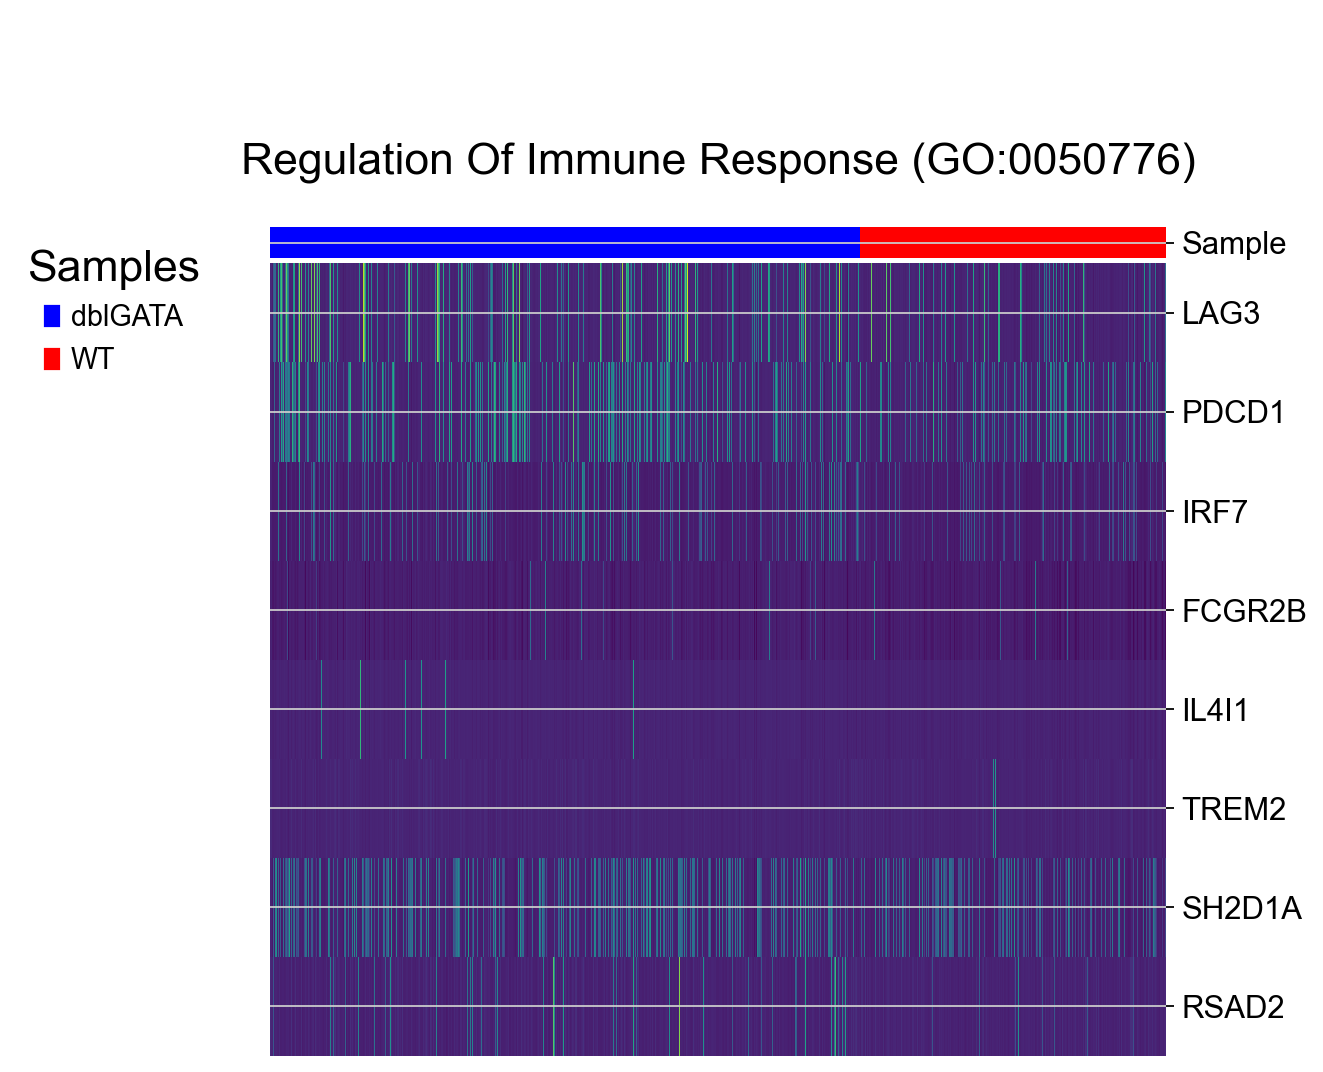

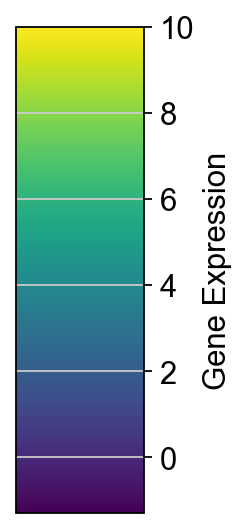

In [100]:

import matplotlib.patches as mpatches

genes = res.res2d.Lead_genes.iloc[i].split(";")

# Extract the relevant subset of the dataframe
df_genes = res.heatmat.loc[genes]

# Create an annotation dataframe based on column names starting with "GP" or "WP"
samples = df_genes.columns
sample_groups = ['dblGATA' if sample.startswith('GP') else 'WT' for sample in samples]
sample_annotation = pd.DataFrame({'Sample': sample_groups}, index=samples)

# Create a colormap for the sample groups
col_colors = sample_annotation['Sample'].map({'dblGATA': 'blue', 'WT': 'red'})

# Create the heatmap without the legend
g = sns.clustermap(data=df_genes,
                   col_cluster=False,
                   row_cluster=False,
                   z_score=None,
                   cmap=plt.cm.viridis,
                   figsize=(10, 8),
                   col_colors=col_colors,
                   xticklabels=False, cbar_pos=None)

# Remove the y-axis label
g.ax_heatmap.set_ylabel('')

# Adjust layout to make space for the title
plt.subplots_adjust(left=0.3, top=0.85, right=1)

# Center the title and adjust its position
g.ax_heatmap.set_title(res.res2d.Term.iloc[i], pad=40, loc='center', size=20)

# Add the custom legend for sample groups at the left center of the heatmap
legend_handles_samples = [
    mpatches.Patch(color='blue', label='dblGATA'),
    mpatches.Patch(color='red', label='WT')
]
g.ax_heatmap.legend(handles=legend_handles_samples, loc='upper left', bbox_to_anchor=(-0.3, 1.05), frameon=False, title='Samples')

# Show the heatmap
plt.show()

# Create a separate figure for the color bar
fig, ax = plt.subplots(figsize=(2, 4))  # Adjust the size as needed
fig.subplots_adjust(left=0.3, right=0.7)

# Use the color bar from the clustermap
cb = fig.colorbar(g.ax_heatmap.collections[0], cax=ax, orientation='vertical')
cb.set_label('Gene Expression')

# Show the color bar plot with numbers
plt.show()

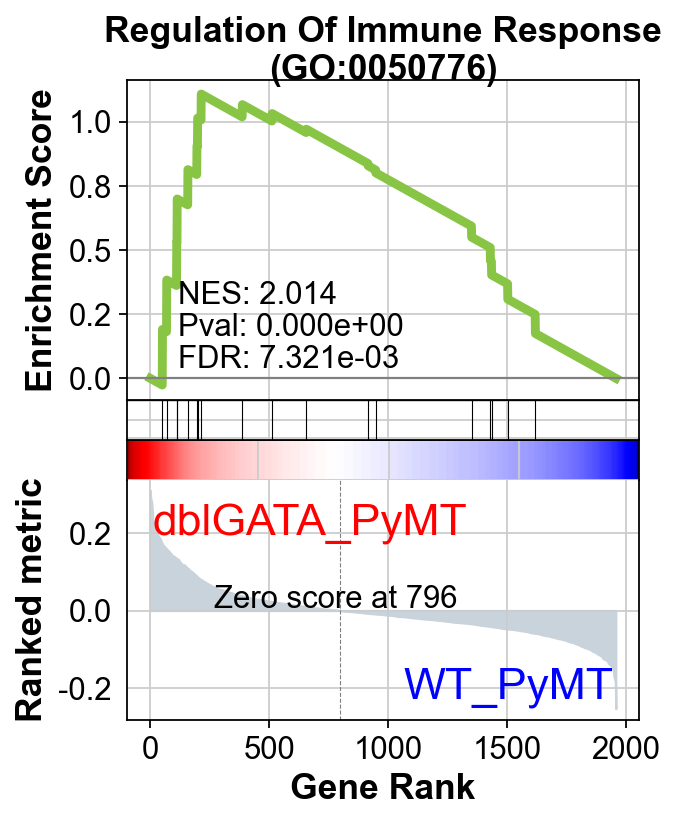

In [102]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms=term[7])

In [103]:
import networkx as nx
nodes, edges = gp.enrichment_map(res.res2d)

/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


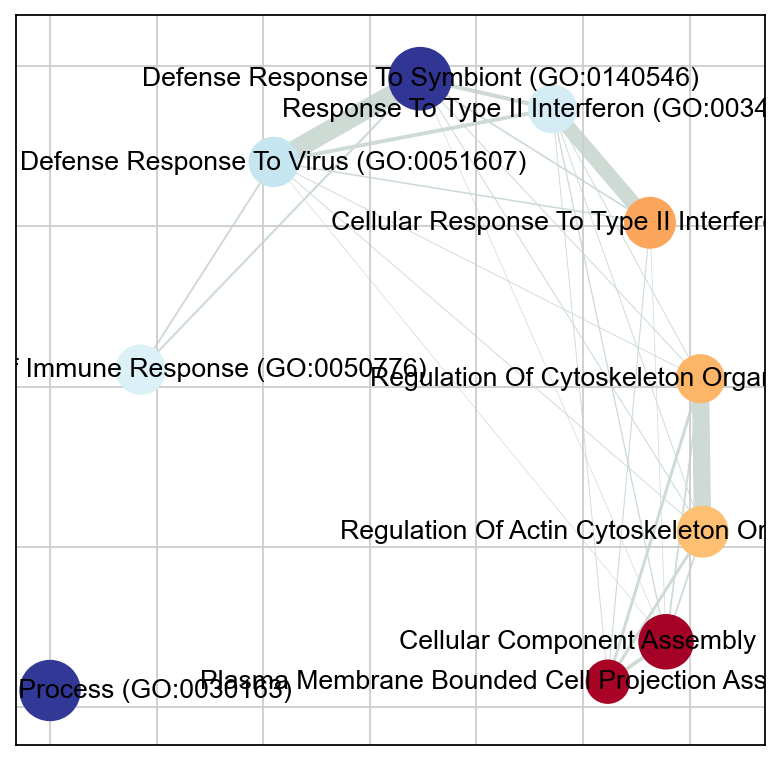

In [104]:
# build graph
G = nx.from_pandas_edgelist(edges,
                            source='src_idx',
                            target='targ_idx',
                            edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])

# Add missing node if there is any
for node in nodes.index:
    if node not in G.nodes():
        G.add_node(node)

fig, ax = plt.subplots(figsize=(6, 6))

# init node cooridnates
pos=nx.layout.spiral_layout(G)
#node_size = nx.get_node_attributes()
# draw node
nx.draw_networkx_nodes(G,
                       pos=pos,
                       cmap=plt.cm.RdYlBu,
                       node_color=list(nodes.NES),
                       node_size=list(nodes.Hits_ratio *1000))
# draw node label
nx.draw_networkx_labels(G,
                        pos=pos,
                        labels=nodes.Term.to_dict())
# draw edge
edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
nx.draw_networkx_edges(G,
                       pos=pos,
                       width=list(map(lambda x: x*10, edge_weight)),
                       edge_color='#CDDBD4')
plt.show()


In [106]:
# find degs

bdata.layers['lognorm'] = bdata.X

sc.tl.rank_genes_groups(bdata,
                        groupby='sample',
                        use_raw=False,
                        layer='lognorm',
                        method='wilcoxon',
                        groups=["dblGATA_PyMT"],
                        reference='WT_PyMT')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


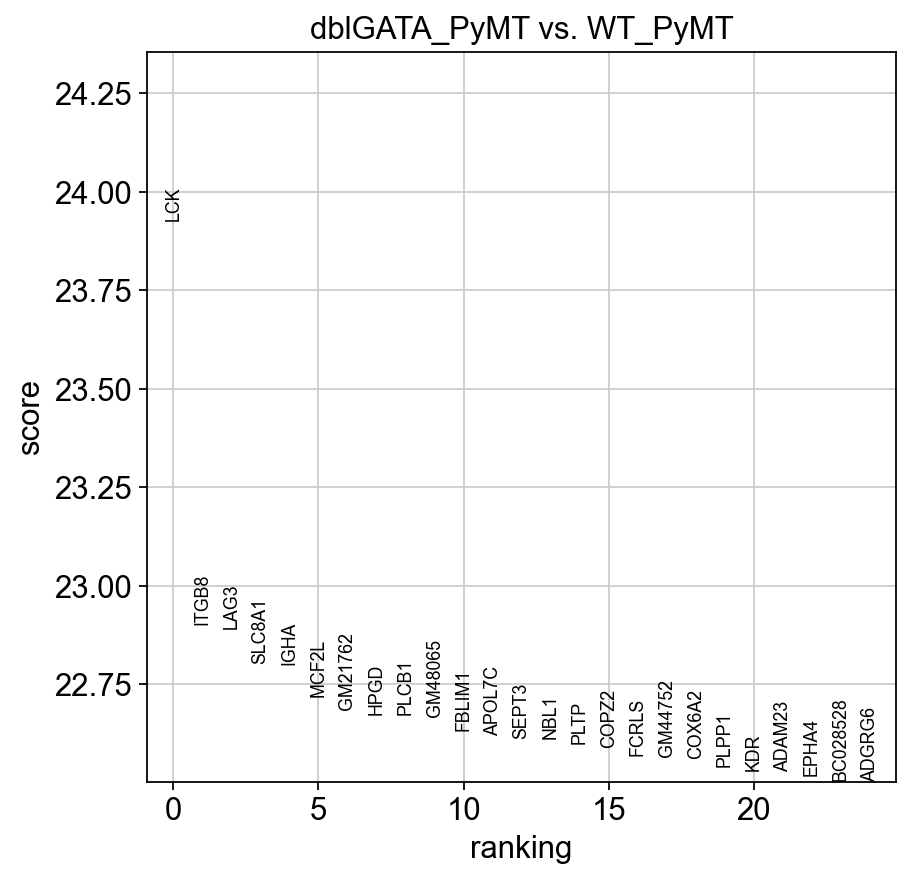

In [107]:
sc.pl.rank_genes_groups(bdata, n_genes=25, sharey=False)

In [108]:
# get deg result
result = bdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [109]:
degs.head(25)

,dblGATA_PyMT_names,dblGATA_PyMT_scores,dblGATA_PyMT_pvals,dblGATA_PyMT_pvals_adj,dblGATA_PyMT_logfoldchanges
0,LCK,23.927818,1.572897e-126,3.079733e-123,1.386665
1,ITGB8,22.902527,4.384437e-116,3.644822e-113,1.373038
2,LAG3,22.891981,5.584507e-116,3.644822e-113,2.340104
3,SLC8A1,22.803089,4.272743e-115,1.755064e-112,-0.500959
4,IGHA,22.800999,4.481778e-115,1.755064e-112,NaN
5,MCF2L,22.717850,2.984588e-114,9.739704e-112,-0.559945
6,GM21762,22.685066,6.291345e-114,1.759779e-111,-0.698437
7,HPGD,22.674334,8.028711e-114,1.764258e-111,-0.268642
8,PLCB1,22.673012,8.273658e-114,1.764258e-111,-0.446417
9,GM48065,22.669256,9.010512e-114,1.764258e-111,-0.388939


In [110]:
# subset up or down regulated genes
degs_sig = degs[degs.dblGATA_PyMT_pvals_adj	 < 0.05]
degs_up = degs_sig[degs_sig.dblGATA_PyMT_logfoldchanges > 0]
degs_dw = degs_sig[degs_sig.dblGATA_PyMT_logfoldchanges < 0]

In [111]:
# Enricr API
enr_up = gp.enrichr(degs_up.dblGATA_PyMT_names,
                    gene_sets='GO_Biological_Process_2023',
                    outdir=None)

In [112]:
# trim (go:...)
enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]

/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


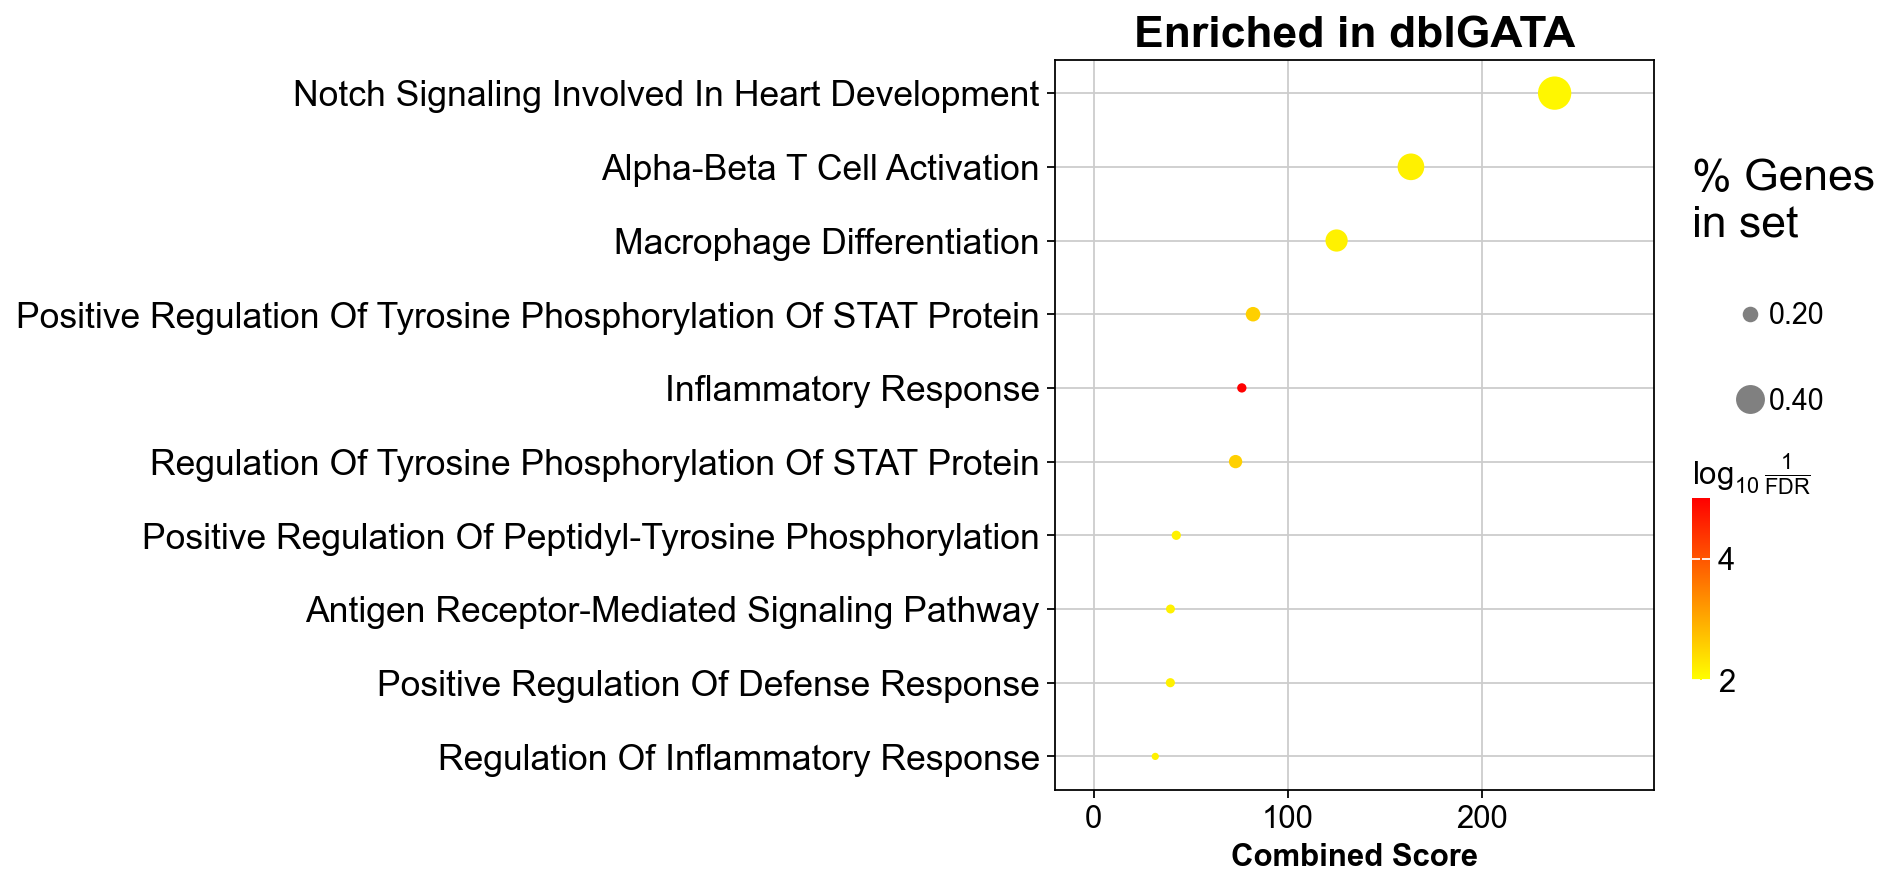

In [115]:
# dotplot
gp.dotplot(enr_up.res2d, figsize=(6,6), title="Enriched in dblGATA", cmap = plt.cm.autumn_r)
plt.show()

In [116]:
enr_dw = gp.enrichr(degs_dw.dblGATA_PyMT_names,
                    gene_sets='GO_Biological_Process_2023',
                    outdir=None)

/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


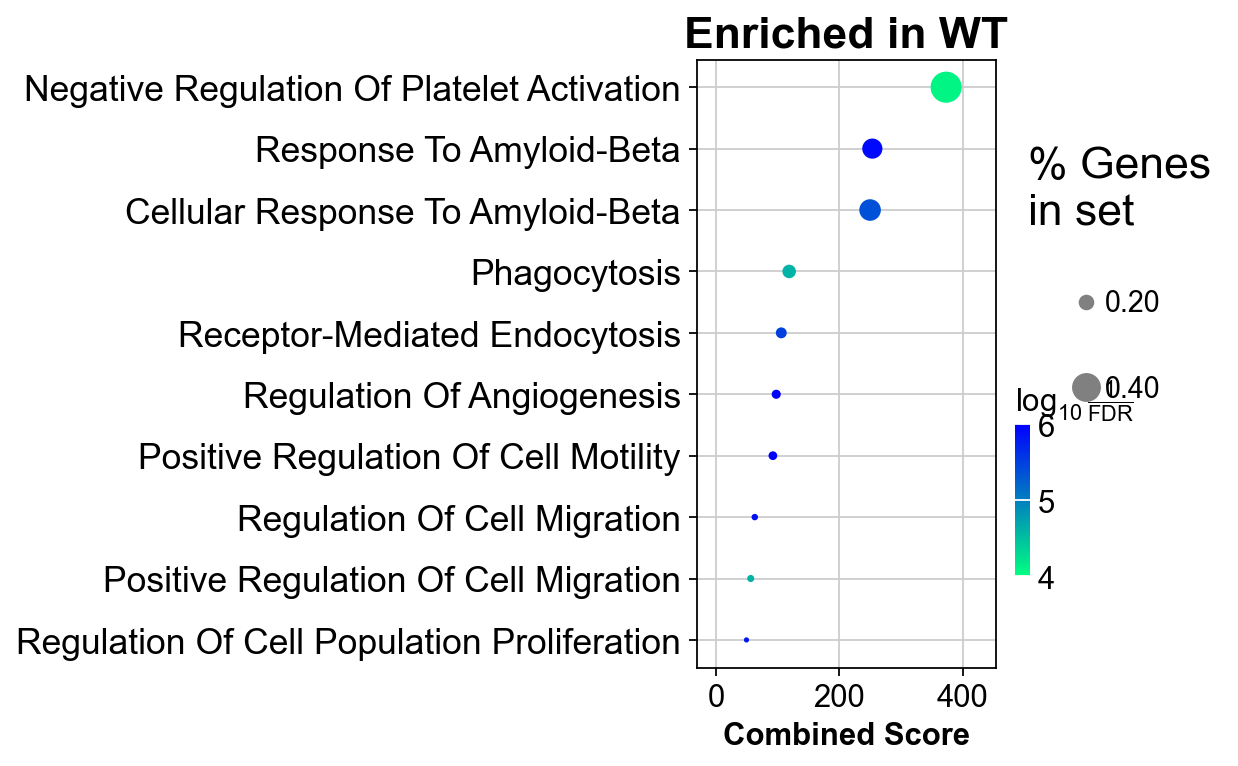

In [117]:
enr_dw.res2d.Term = enr_dw.res2d.Term.str.split(" \(GO").str[0]
gp.dotplot(enr_dw.res2d,
           figsize=(3,5),
           title="Enriched in WT",
           cmap = plt.cm.winter_r,
           size=5)
plt.show()

In [118]:
# concat results
enr_up.res2d['UP_DW'] = "UP"
enr_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_up.res2d.head(), enr_dw.res2d.head()])

In [119]:
from gseapy.scipalette import SciPalette
sci = SciPalette()
NbDr = sci.create_colormap()

/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


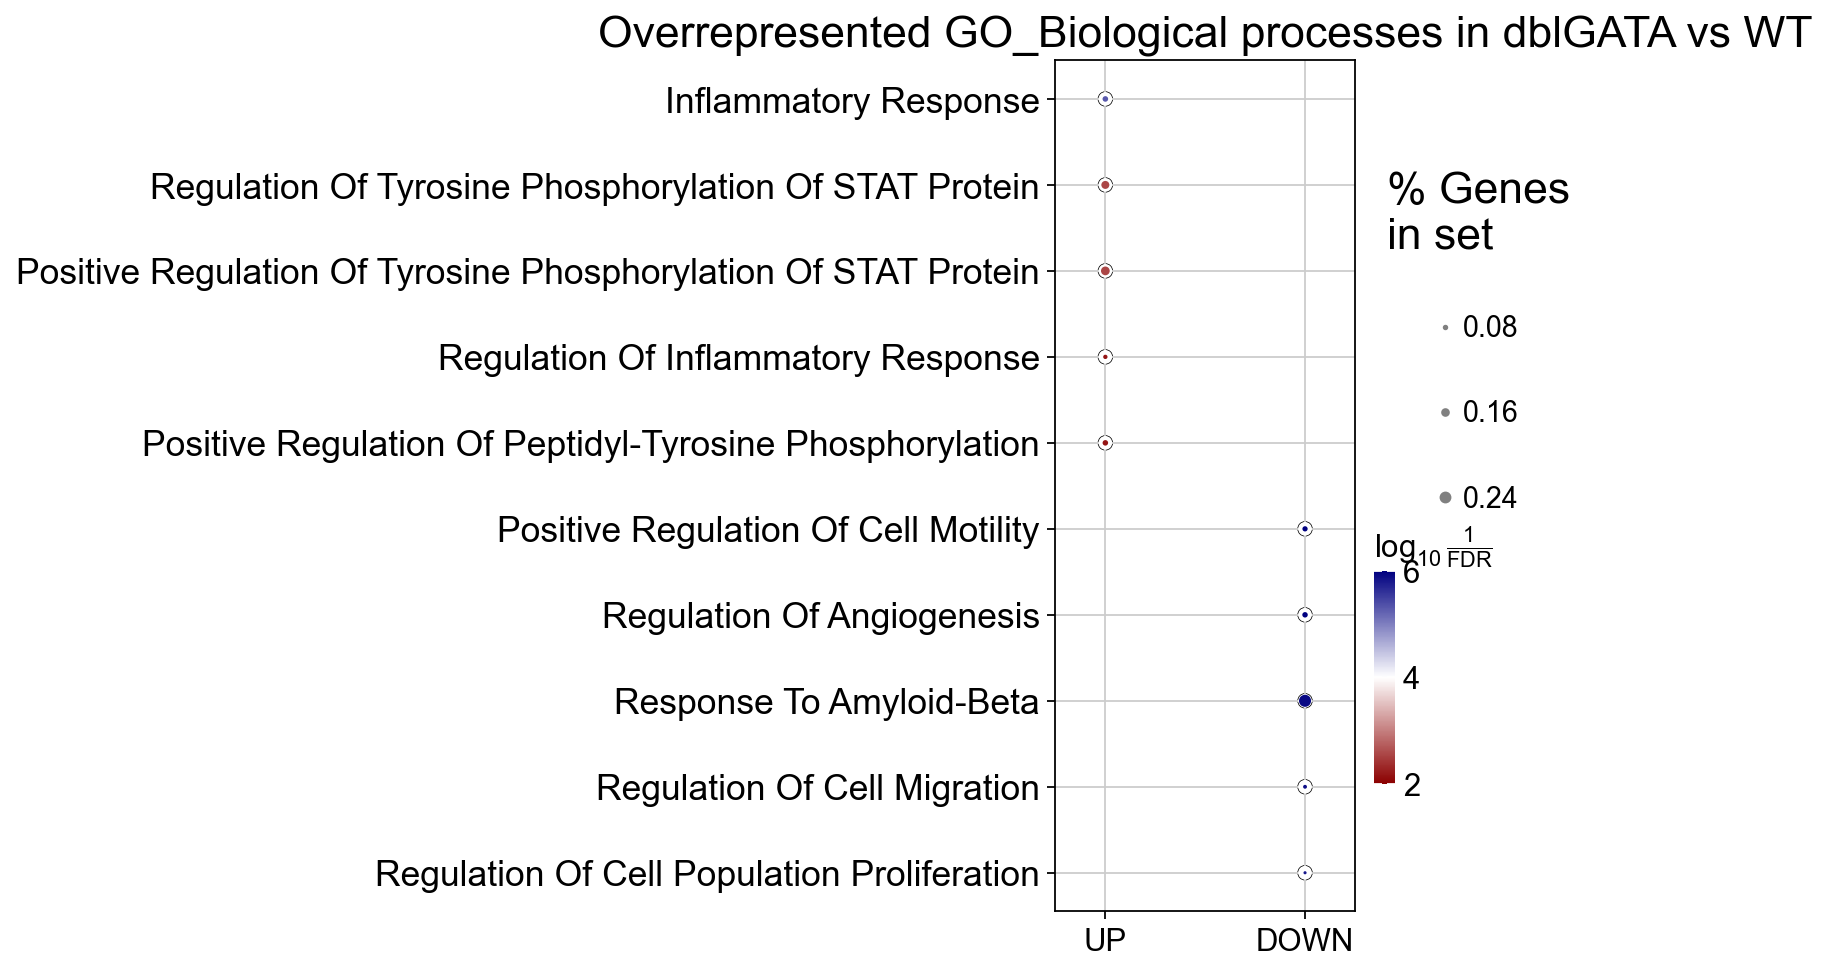

In [130]:
# display multi-datasets
ax = gp.dotplot(enr_res,figsize=(3,7),
                x='UP_DW',
                x_order = ["UP","DOWN"],
                title="Overrepresented GO_Biological processes in dblGATA vs WT",
                cmap = NbDr.reversed(),
                size=3,
                show_ring=True)

# Modify the title to not be bold
ax.set_title("Overrepresented GO_Biological processes in dblGATA vs WT", fontsize=20, fontweight='normal')

ax.set_xlabel("")
plt.show()

/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/liza/PycharmProjects/jupiterscRNA/.venv/lib/python3.10/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


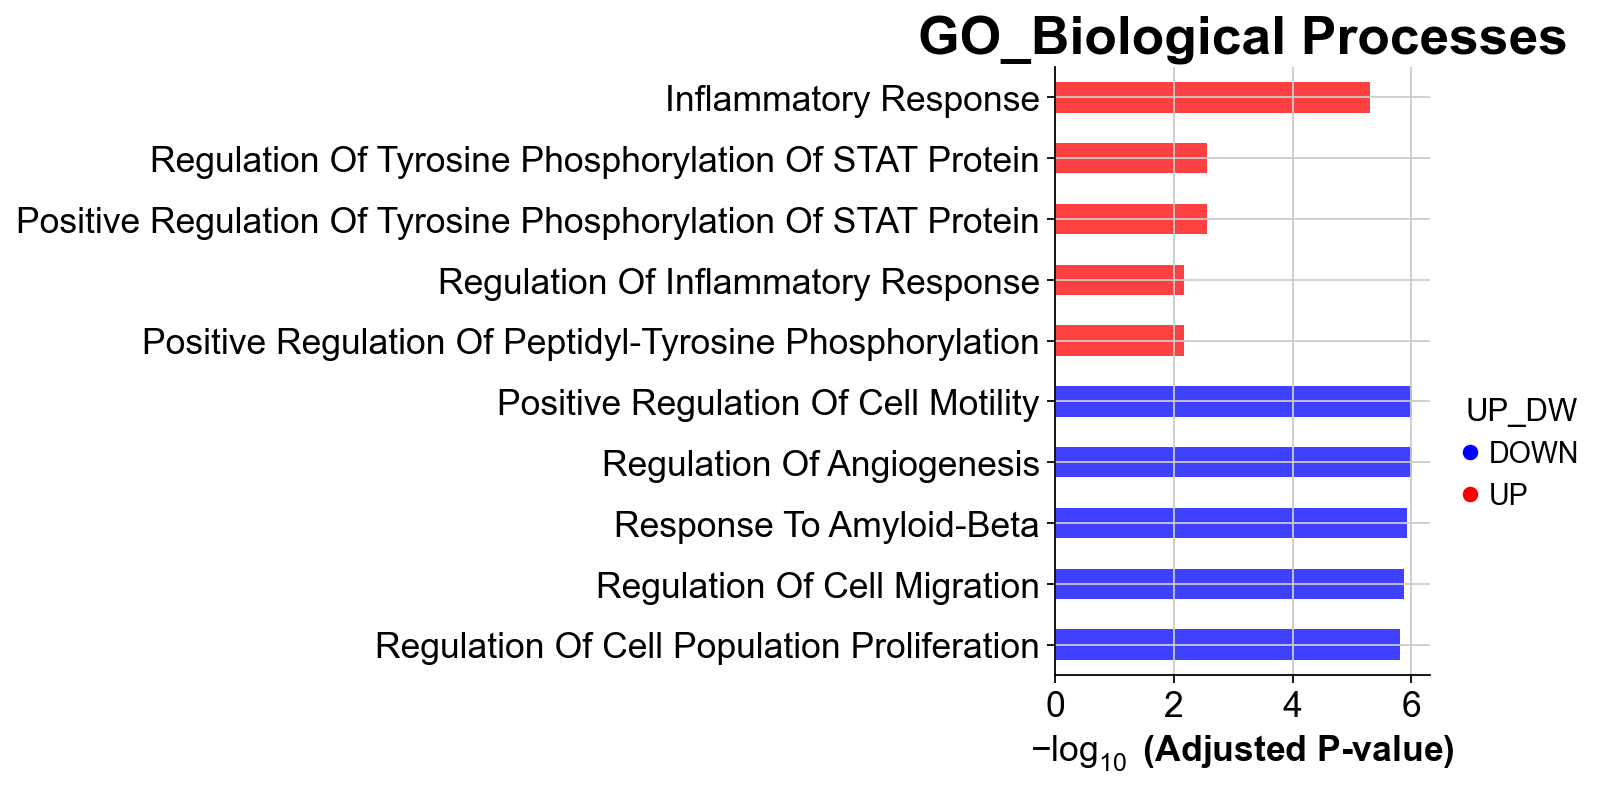

In [101]:
ax = gp.barplot(enr_res, figsize=(3,5),
                group ='UP_DW',
                title ="GO_Biological Processes",
                color = ['b','r'])

In [9]:
df_Exh_T.columns

Index(['genes', 'logfoldchanges', 'pvals', 'pvals_adj', 'Cytokin',
       'Sec_factor', 'Receptor'],
      dtype='object')

In [16]:
# List of dataframes
dfs = [df_Exh_T, df_Eff_CD8, df_Eff_CD4_T, df_Th17, df_naive, df_memory]

# Initialize empty lists to store filtered dataframes
dfs_up = []
dfs_down = []

# Loop through each dataframe and apply filters
for df in dfs:
    # Filter for upregulated genes
    df_up = df[(df['logfoldchanges'] > 1) & (df['pvals'] < 0.05) & (df['pvals_adj'] < 0.05)]
    dfs_up.append(df_up)
    
    # Filter for downregulated genes
    df_down = df[(df['logfoldchanges'] < -1) & (df['pvals'] < 0.05) & (df['pvals_adj'] < 0.05)]
    dfs_down.append(df_down)

# Concatenate all upregulated and downregulated DataFrames respectively
df_up = pd.concat(dfs_up, ignore_index=True)
df_down = pd.concat(dfs_down, ignore_index=True)

In [17]:
# Write the DataFrame to a CSV file
df_up.to_csv('/home/liza/Documents/PhD/scRNAseq_Inbal/list_of_UPP_genes_T_cells.csv', index=False)
df_down.to_csv('/home/liza/Documents/PhD/scRNAseq_Inbal/list_of_DOWN_genes_T_cells.csv', index=False)